In [1]:
import re
import networkx as nx
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from gensim.models import KeyedVectors


def train_tfidf_model(path):
    documents = []
    for filename in os.listdir(path):
        if filename.endswith('.tok'):
            with open(os.path.join(path, filename), 'r', encoding='utf-8') as file:
                # ファイルごとにドキュメントを作成
                document = []
                for line in file:
                    words = re.split('\t|\s', line.strip())  # タブとスペースで分割
                    document.extend(words)
                documents.append(' '.join(document))
    print("tokファイル全体のdocuments:", documents)
    # TF-IDFベクトルライザの初期化とトレーニング
    vectorizer = TfidfVectorizer()
    vectorizer.fit(documents)
    # モデルの保存
    with open('tfidf_model.pkl', 'wb') as file:
        pickle.dump(vectorizer, file)
    print("TF-IDFモデルがトレーニングされ、'tfidf_model.pkl'として保存されました。")
    return vectorizer

# word_listから重要な単語リストを生成する関数
def generate_important_word_list(model, word_list):
    document = " ".join(word_list)
    tfidf_matrix = model.transform([document])
    tfidf_scores = tfidf_matrix.toarray().flatten()
    feature_names = model.get_feature_names_out()
    word_scores = {word: tfidf_scores[idx] for idx, word in enumerate(feature_names) if word in word_list}
    print("word_scores:",word_scores)
    # 上位10%の単語を選出
    threshold = np.percentile(list(word_scores.values()), 90)
    important_word_list = [word for word, score in word_scores.items() if score >= threshold]

    # TF-IDFモデルにない単語を追加
    for word in word_list:
        if word not in feature_names:
            important_word_list.append(word)

    important_word_list=list(set(important_word_list))

    return important_word_list
"""
2024/01/19　w2Vのベクトルからグラフを作成して特徴量を算出
・計算量が多くなるため、どのワードをノードとして取り出すかが重要。
"""

if __name__ == '__main__':
    # Tf-idfモデル作成
    path="/Users/hironobu/Desktop/tryagaindata"
    tf_idf_vectorizer = train_tfidf_model(path)

    # w2v model作成
    model_path = '/Users/hironobu/Desktop/entity_vector/entity_vector.model.txt'
    wv = KeyedVectors.load_word2vec_format(model_path, binary=False)

    # 類似度の閾値と上位N個を取り出すための数
    sth = 0.25  # 例えば 0.5
    N = 20  # 上位N個
    ih = 0.2 # word2Vecモデルに含まれていない単語についての類似度の代替値

    # テキストデータの読み込み（例）
    word_list = ["沖縄","私","パラダイス","洗浄","遊び","リレー","カレーライス","戦争","ドッキリ","海","海水浴","ダンス",
                 "剣道","精神","ラッキー","悲しい","困る","落書き"]  # あなたのテキストデータ

    # important_word_listの作成
    important_word_list= generate_important_word_list(model=tf_idf_vectorizer, word_list=word_list)
    print("important_word_list:", important_word_list)

    # ネットワークグラフの作成
    G = nx.Graph()
    for wi in important_word_list:
        similarities = []
        for wj in word_list:
            if wi != wj:
                # Word2Vecモデルに単語が含まれているか確認し、類似度を計算
                similarity = wv.similarity(wi, wj) if wi in wv.key_to_index and wj in wv.key_to_index else ih
                if similarity >= sth:
                    similarities.append((similarity, wj))
        print("similarities:", similarities)
        # 類似度が最も高い上位N個のwjを取り出す
        wi_similar_list = [word for _, word in sorted(similarities, reverse=True)[:N]]
        print("wi_similar_list:",wi_similar_list)
        # グラフにノードとエッジを追加
        G.add_node(wi)
        G.add_edges_from([(wi, w2) for w2 in wi_similar_list])

    # 特徴量の計算
    try:
        average_distance = nx.average_shortest_path_length(G)
    except nx.NetworkXError:
        average_distance = float('inf')  # 非連結グラフの場合

    cluster_coefficient = nx.average_clustering(G)
    closeness_centrality = nx.closeness_centrality(G)
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)

    # ノード間の距離の計算（例）
    distance = dict(nx.shortest_path_length(G))

    # 特徴量を辞書型に格納
    features = {
        "average_distance": average_distance,
        "cluster_coefficient": cluster_coefficient,
        "closeness_centrality": closeness_centrality,
        "degree_centrality": degree_centrality,
        "betweenness_centrality": betweenness_centrality,
        "distance": distance
    }

    # 特徴量を出力
    print(features)


tokファイル全体のdocuments: ['シンデレラ 話 すごい お母さん 親 いない シンデレラ まま 母 育てる られる ん すごい 姉 義理 姉 ２ 人 愛す れる いる シンデレラ 雑用 する せる られる いる 中 シンデレラ 王子 様 出会う ガラスの靴 ぴったり 合う の 王子 様 結婚 する 相手 条件 こと それ シンデレラ 家 回る くる 靴 履く せる ん まあ 姉 ２ 人 合う シンデレラ ぴったり シンデレラ ぴったり 合う シンデレラ 王子 様 結婚 する ハッピーエンド なる よう 話 ちょっと あんまり 詳しい 覚える ちょっと', 'まあ まあ 食欲 ある それ 全部 排出 する れる しまう 感じ する ご飯 いつ 全部 食べる 右手 昨日 思う 希望 する てる あんまり ガミガミ 言う 人 いる やさしい 異人 多い 安心 できる 環境 思う 手 震える いる 私 幻聴 幻覚 見る ここに いる の 人 ちょっと ガミガミ 言う くる 私 ほう 先 水 くむ 並ぶ たって 言う れる 他人 分かる ストレス ちょっと 不安定 なる 両手 南 * 移る れる おっしゃる 私 先 はず ライン 見る Twitter 見る 土曜日 行く 店 行く いい ワタナベ 先生 許可 くれる それ 楽しみ する 西荻窪 セレクトショップ 日曜日 行く 車 行う いい 許可 出る 婚約者 関係 者 行く ２ カ月 半 行く てる 思う 入院 する の 10月 １ ８ 日 表現 自由 * 表現 できる とこ いい 雑貨 ある 本 ある 手作り 物 創造性 豊か 物 多い 大丈夫 身の回り 調子 悪意 人 ガミガミ 言う れる こと ストレス 私 ん * ナースステーション 言う 人 こう 言う れる ん どう ふう 確認 する もらう 皆 ストレス 抱える 来る てる やめる ほしい なる 思う 消灯 時間 決まる てる 分館 ない 何 怒る てる 怒る れる ちゃう テレビ 見る 時 見る 見る 時 見る ニュース 見る する どう 特に お小遣い １ 円 もらう てる お腹 すく 仕方がない かなう 感じ 売店 外 買う くる ほう 安い お母さん 差し入れる くれる 月 水 金 来る くれる 飲み物 食べ物 栄養 価 ある もの 作る 

findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Fon

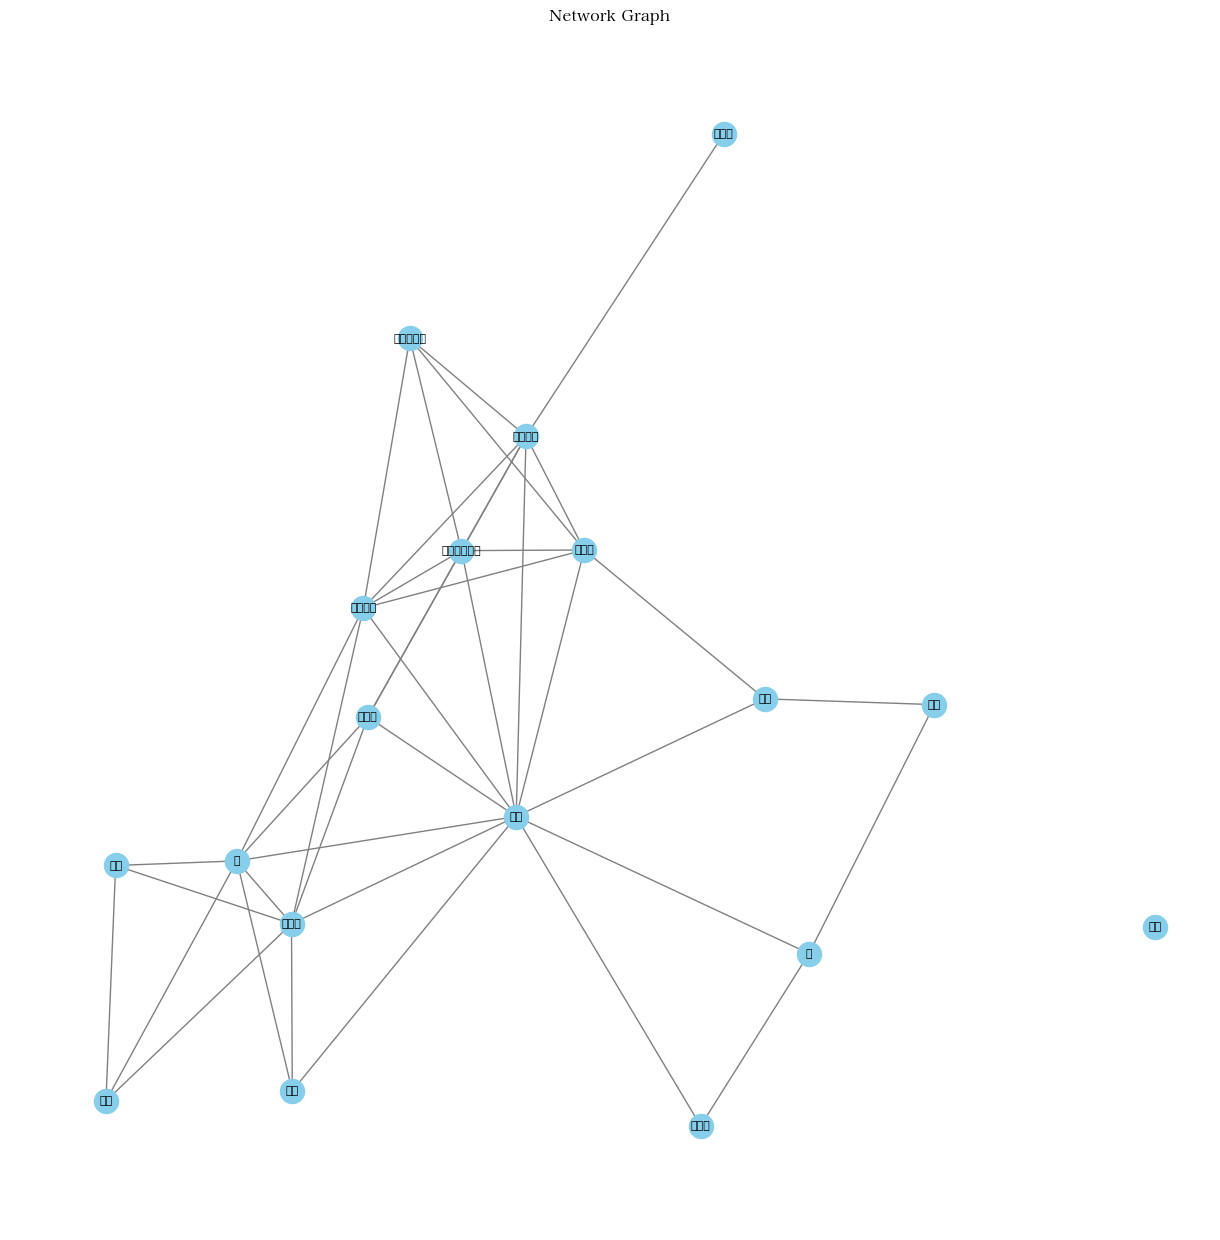

In [14]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib as mpl

# 日本語フォントの設定
mpl.rcParams['font.family'] = 'Hiragino Mincho ProN'

# グラフの可視化
plt.figure(figsize=(12, 12))  # キャンバスのサイズ設定
pos = nx.spring_layout(G, k=0.75)  # kパラメータを増やしてノード間の距離を広げる
nx.draw(G, pos, with_labels=False, node_color='skyblue', edge_color='gray')  # ラベルは後で描画
nx.draw_networkx_labels(G, pos, font_size=8, font_family='IPAexGothic')  # フォントサイズを小さくし、フォントファミリーを設定
plt.title("Network Graph")
plt.show()

# 2024/01/23 修正加えたものが以下

In [ ]:
import re
import networkx as nx
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.font_manager as fm


def train_tfidf_model(path):
    documents = []
    for filename in os.listdir(path):
        if filename.endswith('.tok'):
            with open(os.path.join(path, filename), 'r', encoding='utf-8') as file:
                # ファイルごとにドキュメントを作成
                document = []
                for line in file:
                    words = re.split('\t|\s', line.strip())  # タブとスペースで分割
                    document.extend(words)
                documents.append(' '.join(document))
    print("tokファイル全体のdocuments:", documents)
    # TF-IDFベクトルライザの初期化とトレーニング
    vectorizer = TfidfVectorizer()
    vectorizer.fit(documents)
    # モデルの保存
    with open('tfidf_model.pkl', 'wb') as file:
        pickle.dump(vectorizer, file)
    print("TF-IDFモデルがトレーニングされ、'tfidf_model.pkl'として保存されました。")
    return vectorizer

# word_listから重要な単語リストを生成する関数
def generate_important_word_list(model, word_list):
    # word_listの単語をスペース区切りの文書として扱う
    document = " ".join(word_list)
    # トレーニング済みモデルを使用してTF-IDF変換
    tfidf_matrix = model.transform([document])
    tfidf_scores = tfidf_matrix.toarray().flatten()
    # 単語とそのスコアを辞書に格納
    feature_names = model.get_feature_names_out()
    word_scores = {word: tfidf_scores[idx] for idx, word in enumerate(feature_names) if word in word_list}
    print("word_scores:",word_scores)
    # スコアに基づいて単語をソート
    sorted_words = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)
    # 上位10%の単語を選出
    top_10_percent = int(len(sorted_words) * 0.1)
    important_word_list = [word for word, score in sorted_words[:top_10_percent]]
    print("important_word_list:", important_word_list)
    # TF-IDFモデルにない単語を追加
    for word in word_list:
        if word not in feature_names:
            important_word_list.append(word)

    important_word_list=list(set(important_word_list))
    print("important_word_list:", important_word_list)
    return important_word_list


# 類似度が閾値以上の単語リストを作成し、グラフに追加する関数
def extend_graph(G, word_list, graph_word_list, sth, N, ih):
    new_graph_word_list = set()
    # word_listからgraph_word_listの要素を除外
    remaining_word_list = [word for word in word_list if word not in graph_word_list]
    print("remaining_word_list:", remaining_word_list)
    
    for wi in graph_word_list:
        over_sth_word_list = []

        for wj in remaining_word_list:
            if wi != wj:
                similarity = wv.similarity(wi, wj) if wi in wv.key_to_index and wj in wv.key_to_index else ih
                if similarity >= sth:
                    over_sth_word_list.append(wj)

        if len(over_sth_word_list) >= N:
            if wi not in G:
                G.add_node(wi)
            for wh in over_sth_word_list[:N]:
                if wh not in G:
                    G.add_node(wh)
                if not G.has_edge(wi, wh):
                    G.add_edge(wi, wh)
            new_graph_word_list.update(over_sth_word_list[:N])

    return new_graph_word_list


"""
2024/01/19　w2Vのベクトルからグラフを作成して特徴量を算出
・計算量が多くなるため、どのワードをノードとして取り出すかが重要。
"""

if __name__ == '__main__':
    # Tf-idfモデル作成
    path="/Users/hironobu/Desktop/tryagaindata"
    tf_idf_vectorizer = train_tfidf_model(path)

    # w2v model作成
    model_path = '/Users/hironobu/Desktop/entity_vector/entity_vector.model.txt'
    wv = KeyedVectors.load_word2vec_format(model_path, binary=False)

    # 類似度の閾値と上位N個を取り出すための数
    sth = 0.335  # 例えば 0.5
    N = 3  # 上位N個
    ih = 0 # word2Vecモデルに含まれていない単語についての類似度の代替値
    
    # テキストデータの読み込み（例）
    word_list = ["沖縄","私","パラダイス","洗浄","遊び","リレー","カレーライス","戦争","ドッキリ","海","海水浴","ダンス",
                 "剣道","精神","ラッキー","悲しい","困る","落書き","シンデレラ", "話",
                 "すごい", "お母さん", "親", "いない","シンデレラ","まま","母","育てる","義理","姉","愛す"]  # あなたのテキストデータ
    
    # important_word_listの作成
    important_word_list= generate_important_word_list(model=tf_idf_vectorizer, word_list=word_list)
    print("important_word_list:", important_word_list)
    
    # ネットワークグラフの作成
    G = nx.Graph()
    
    # word_list, graph_word_listを用意
    graph_word_list = important_word_list  # 初期値はimportant_word_list
    
    # メインのwhileループ
    while True:
        new_graph_word_list = extend_graph(G, word_list, graph_word_list, sth, N, ih)
        if len(new_graph_word_list) < N:
            break  # 新たなワードリストの要素数がN未満なら終了
        graph_word_list = new_graph_word_list  # graph_word_listを更新

tokファイル全体のdocuments: ['シンデレラ 話 すごい お母さん 親 いない シンデレラ まま 母 育てる られる ん すごい 姉 義理 姉 ２ 人 愛す れる いる シンデレラ 雑用 する せる られる いる 中 シンデレラ 王子 様 出会う ガラスの靴 ぴったり 合う の 王子 様 結婚 する 相手 条件 こと それ シンデレラ 家 回る くる 靴 履く せる ん まあ 姉 ２ 人 合う シンデレラ ぴったり シンデレラ ぴったり 合う シンデレラ 王子 様 結婚 する ハッピーエンド なる よう 話 ちょっと あんまり 詳しい 覚える ちょっと', 'まあ まあ 食欲 ある それ 全部 排出 する れる しまう 感じ する ご飯 いつ 全部 食べる 右手 昨日 思う 希望 する てる あんまり ガミガミ 言う 人 いる やさしい 異人 多い 安心 できる 環境 思う 手 震える いる 私 幻聴 幻覚 見る ここに いる の 人 ちょっと ガミガミ 言う くる 私 ほう 先 水 くむ 並ぶ たって 言う れる 他人 分かる ストレス ちょっと 不安定 なる 両手 南 * 移る れる おっしゃる 私 先 はず ライン 見る Twitter 見る 土曜日 行く 店 行く いい ワタナベ 先生 許可 くれる それ 楽しみ する 西荻窪 セレクトショップ 日曜日 行く 車 行う いい 許可 出る 婚約者 関係 者 行く ２ カ月 半 行く てる 思う 入院 する の 10月 １ ８ 日 表現 自由 * 表現 できる とこ いい 雑貨 ある 本 ある 手作り 物 創造性 豊か 物 多い 大丈夫 身の回り 調子 悪意 人 ガミガミ 言う れる こと ストレス 私 ん * ナースステーション 言う 人 こう 言う れる ん どう ふう 確認 する もらう 皆 ストレス 抱える 来る てる やめる ほしい なる 思う 消灯 時間 決まる てる 分館 ない 何 怒る てる 怒る れる ちゃう テレビ 見る 時 見る 見る 時 見る ニュース 見る する どう 特に お小遣い １ 円 もらう てる お腹 すく 仕方がない かなう 感じ 売店 外 買う くる ほう 安い お母さん 差し入れる くれる 月 水 金 来る くれる 飲み物 食べ物 栄養 価 ある もの 作る 

In [ ]:
# 特徴量の計算
if len(G.nodes) == 0:
    print("グラフにノードが存在しないため、特徴量を計算できません。")
    features = {}
else:
    try:
        average_distance = nx.average_shortest_path_length(G)
    except nx.NetworkXError:
        average_distance = float('inf')  # 非連結グラフの場合

    cluster_coefficient = nx.average_clustering(G)
    closeness_centrality = nx.closeness_centrality(G)
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)

    # ノード間の距離の計算（例）
    distance = dict(nx.shortest_path_length(G))

    # 特徴量を辞書型に格納
    features = {
        "average_distance": average_distance,
        "cluster_coefficient": cluster_coefficient,
        "closeness_centrality": closeness_centrality,
        "degree_centrality": degree_centrality,
        "betweenness_centrality": betweenness_centrality,
        "distance": distance
    }

# 特徴量を出力
print(features)


# 日本語フォントの設定
#fm.get_font_config()
#plt.rcParams['font.family'] = 'IPAexGothic'

# グラフの可視化
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray')
plt.title("Network Graph")
plt.show()

# 2024/01/26 

In [1]:
pip install japanize-matplotlib

  Using cached japanize_matplotlib-1.1.3-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [1]:
import re
import networkx as nx
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.font_manager as fm
import japanize_matplotlib


def train_tfidf_model(path):
    documents = []
    for filename in os.listdir(path):
        if filename.endswith('.tok'):
            with open(os.path.join(path, filename), 'r', encoding='utf-8') as file:
                # ファイルごとにドキュメントを作成
                document = []
                for line in file:
                    words = re.split('\t|\s', line.strip())  # タブとスペースで分割
                    document.extend(words)
                documents.append(' '.join(document))
    print("tokファイル全体のdocuments:", documents)
    # TF-IDFベクトルライザの初期化とトレーニング
    vectorizer = TfidfVectorizer()
    vectorizer.fit(documents)
    # モデルの保存
    with open('tfidf_model.pkl', 'wb') as file:
        pickle.dump(vectorizer, file)
    print("TF-IDFモデルがトレーニングされ、'tfidf_model.pkl'として保存されました。")
    return vectorizer

# word_listから重要な単語リストを生成する関数
def generate_important_word_list(model, word_list):
    # word_listの単語をスペース区切りの文書として扱う
    document = " ".join(word_list)
    # トレーニング済みモデルを使用してTF-IDF変換
    tfidf_matrix = model.transform([document])
    tfidf_scores = tfidf_matrix.toarray().flatten()
    # 単語とそのスコアを辞書に格納
    feature_names = model.get_feature_names_out()
    word_scores = {word: tfidf_scores[idx] for idx, word in enumerate(feature_names) if word in word_list}
    print("word_scores:",word_scores)
    # スコアに基づいて単語をソート
    sorted_words = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)
    # 上位10%の単語を選出
    top_10_percent = int(len(sorted_words) * 0.1)
    important_word_list = [word for word, score in sorted_words[:top_10_percent]]
    print("important_word_list:", important_word_list)
    # TF-IDFモデルにない単語を追加
    for word in word_list:
        if word not in feature_names:
            important_word_list.append(word)

    important_word_list=list(set(important_word_list))
    print("important_word_list:", important_word_list)
    return important_word_list


# 類似度が閾値以上の単語リストを作成し、グラフに追加する関数
def extend_graph(G, word_list, graph_word_list, processed_words, sth, N, ih):
    new_graph_word_list = set()

    for wi in graph_word_list:
        if wi in processed_words:
            continue  # 既に処理された単語はスキップする

        over_sth_word_list = []

        for wj in word_list:
            if wi != wj:
                similarity = wv.similarity(wi, wj) if wi in wv.key_to_index and wj in wv.key_to_index else ih
                if similarity >= sth:
                    over_sth_word_list.append(wj)

        if len(over_sth_word_list) >= N:
            G.add_node(wi)
            for wh in over_sth_word_list[:N]:
                G.add_edge(wi, wh)
            new_graph_word_list.update(over_sth_word_list[:N])
        print("wi, over_sth_word_list:", wi, over_sth_word_list)
        processed_words.add(wi)
    return new_graph_word_list, processed_words

"""
2024/01/19　w2Vのベクトルからグラフを作成して特徴量を算出
・計算量が多くなるため、どのワードをノードとして取り出すかが重要。
"""

if __name__ == '__main__':
    # Tf-idfモデル作成
    path="/Users/hironobu/Desktop/tryagaindata"
    tf_idf_vectorizer = train_tfidf_model(path)

    # w2v model作成
    model_path = '/Users/hironobu/Desktop/entity_vector/entity_vector.model.txt'
    wv = KeyedVectors.load_word2vec_format(model_path, binary=False)

    # 類似度の閾値と上位N個を取り出すための数
    sth = 0.3  # 例えば 0.5
    N = 10  # 上位N個
    ih = 0 # word2Vecモデルに含まれていない単語についての類似度の代替値

    # テキストデータの読み込み（例）
    word_list = ["沖縄","私","パラダイス","洗浄","遊び","リレー","カレーライス","戦争","ドッキリ","海","海水浴","ダンス",
                 "剣道","精神","ラッキー","悲しい","困る","落書き","シンデレラ", "話",
                 "すごい", "お母さん", "親", "いない","シンデレラ","まま","母","育てる","義理","姉","愛す"]# あなたのテキストデータ

    # important_word_listの作成
    important_word_list= generate_important_word_list(model=tf_idf_vectorizer, word_list=word_list)
    print("important_word_list:", important_word_list)

    # ネットワークグラフの作成
    G = nx.Graph()

    # word_list, graph_word_listを用意
    graph_word_list = important_word_list  # 初期値はimportant_word_list
    #word_list = list(set(word_list))

    # メインのwhileループ
    processed_words = set()
    iteration_count = 0
    max_iterations = 10  # 最大繰り返し回数
    while True:
        new_graph_word_list = extend_graph(G, word_list, graph_word_list, processed_words, sth, N, ih)
        if len(new_graph_word_list) < N or iteration_count >= max_iterations:
            break  # 新たなワードリストの要素数がN未満または最大繰り返し回数に達したら終了
        graph_word_list = new_graph_word_list
        iteration_count += 1

    # 特徴量の計算
    if len(G.nodes) == 0:
        print("グラフにノードが存在しないため、特徴量を計算できません。")
        features = {}
    else:
        try:
            average_distance = nx.average_shortest_path_length(G)
        except nx.NetworkXError:
            average_distance = float('inf')  # 非連結グラフの場合

        cluster_coefficient = nx.average_clustering(G)
        closeness_centrality = nx.closeness_centrality(G)
        degree_centrality = nx.degree_centrality(G)
        betweenness_centrality = nx.betweenness_centrality(G)
        # ノード間の距離の計算（例）
        distance = dict(nx.shortest_path_length(G))

        try:
            average_shortest_path_length = nx.average_shortest_path_length(G)
        except nx.NetworkXError:
            average_shortest_path_length = float('inf')  # 非連結グラフの場合

        try:
            diameter = nx.diameter(G)
        except nx.NetworkXError:
            diameter = float('inf')  # 非連結グラフの場合

        clustering_coefficient = nx.average_clustering(G)
        density = nx.density(G)

        # closeness_centralityの平均値の計算
        closeness_centrality_values = nx.closeness_centrality(G)
        average_closeness_centrality = np.mean(list(closeness_centrality_values.values()))

        # 特徴量を辞書型に格納
        features = {
            "number_of_nodes": G.number_of_nodes(),  # ノードの数
            "words_nodes_ratio": G.number_of_nodes() / len(word_list) if word_list else 0,  # words-nodes-ratio
            "average_distance": average_distance,
            "cluster_coefficient": cluster_coefficient,
            "closeness_centrality": closeness_centrality,
            "degree_centrality": degree_centrality,
            "betweenness_centrality": betweenness_centrality,
            "distance": distance,
            "average_shortest_path_length": average_shortest_path_length,
            "diameter": diameter,
            "average_clustering_coefficient": clustering_coefficient,
            "density": density,
            "average_closeness_centrality": average_closeness_centrality
        }

    # 特徴量を出力
    print(features)

tokファイル全体のdocuments: ['シンデレラ 話 すごい お母さん 親 いない シンデレラ まま 母 育てる られる ん すごい 姉 義理 姉 ２ 人 愛す れる いる シンデレラ 雑用 する せる られる いる 中 シンデレラ 王子 様 出会う ガラスの靴 ぴったり 合う の 王子 様 結婚 する 相手 条件 こと それ シンデレラ 家 回る くる 靴 履く せる ん まあ 姉 ２ 人 合う シンデレラ ぴったり シンデレラ ぴったり 合う シンデレラ 王子 様 結婚 する ハッピーエンド なる よう 話 ちょっと あんまり 詳しい 覚える ちょっと', 'まあ まあ 食欲 ある それ 全部 排出 する れる しまう 感じ する ご飯 いつ 全部 食べる 右手 昨日 思う 希望 する てる あんまり ガミガミ 言う 人 いる やさしい 異人 多い 安心 できる 環境 思う 手 震える いる 私 幻聴 幻覚 見る ここに いる の 人 ちょっと ガミガミ 言う くる 私 ほう 先 水 くむ 並ぶ たって 言う れる 他人 分かる ストレス ちょっと 不安定 なる 両手 南 * 移る れる おっしゃる 私 先 はず ライン 見る Twitter 見る 土曜日 行く 店 行く いい ワタナベ 先生 許可 くれる それ 楽しみ する 西荻窪 セレクトショップ 日曜日 行く 車 行う いい 許可 出る 婚約者 関係 者 行く ２ カ月 半 行く てる 思う 入院 する の 10月 １ ８ 日 表現 自由 * 表現 できる とこ いい 雑貨 ある 本 ある 手作り 物 創造性 豊か 物 多い 大丈夫 身の回り 調子 悪意 人 ガミガミ 言う れる こと ストレス 私 ん * ナースステーション 言う 人 こう 言う れる ん どう ふう 確認 する もらう 皆 ストレス 抱える 来る てる やめる ほしい なる 思う 消灯 時間 決まる てる 分館 ない 何 怒る てる 怒る れる ちゃう テレビ 見る 時 見る 見る 時 見る ニュース 見る する どう 特に お小遣い １ 円 もらう てる お腹 すく 仕方がない かなう 感じ 売店 外 買う くる ほう 安い お母さん 差し入れる くれる 月 水 金 来る くれる 飲み物 食べ物 栄養 価 ある もの 作る 

In [6]:
import matplotlib.font_manager as font_manager

font_list = font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

font_names = []
for font_path in font_list:
    try:
        font_name = font_manager.FontProperties(fname=font_path).get_name()
        font_names.append(font_name)
    except Exception as e:
        print(f"エラー発生: {e}, フォントパス: {font_path}")

# 利用可能なフォントの名前を出力
print("インストールされているフォントのリスト:")
for font_name in sorted(set(font_names)):
    print(font_name)


エラー発生: In FT2Font: Could not set the fontsize (invalid pixel size; error code 0x17), フォントパス: /System/Library/Fonts/Supplemental/NISC18030.ttf
エラー発生: In FT2Font: Could not set the fontsize (invalid pixel size; error code 0x17), フォントパス: /System/Library/Fonts/Apple Color Emoji.ttc
インストールされているフォントのリスト:
.Aqua Kana
.Keyboard
.LastResort
.New York
.SF Arabic
.SF Compact
.SF Compact Rounded
.SF NS Mono
.SF NS Rounded
Academy Engraved LET
Al Bayan
Al Nile
Al Tarikh
American Typewriter
Andale Mono
Apple Braille
Apple Chancery
Apple SD Gothic Neo
Apple Symbols
AppleGothic
AppleMyungjo
Arial
Arial Black
Arial Hebrew
Arial Narrow
Arial Rounded MT Bold
Arial Unicode MS
Athelas
Avenir
Avenir Next
Avenir Next Condensed
Ayuthaya
Baghdad
Bangla MN
Bangla Sangam MN
Baskerville
Beirut
Big Caslon
Bodoni 72
Bodoni 72 Oldstyle
Bodoni 72 Smallcaps
Bodoni Ornaments
Bradley Hand
Brush Script MT
Chalkboard
Chalkboard SE
Chalkduster
Charter
Cochin
Comic Sans MS
Copperplate
Corsiva Hebrew
Courier
Courier New
DIN A

In [4]:
from matplotlib import font_manager
for i in font_manager.fontManager.ttflist:
     if ".ttc" in i.fname:
             print(i)

FontEntry(fname='/System/Library/Fonts/Kohinoor.ttc', name='Kohinoor Devanagari', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')
FontEntry(fname='/System/Library/Fonts/KohinoorGujarati.ttc', name='Kohinoor Gujarati', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')
FontEntry(fname='/System/Library/Fonts/Supplemental/Cochin.ttc', name='Cochin', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')
FontEntry(fname='/System/Library/Fonts/Supplemental/Seravek.ttc', name='Seravek', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')
FontEntry(fname='/System/Library/Fonts/NotoNastaliq.ttc', name='Noto Nastaliq Urdu', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')
FontEntry(fname='/System/Library/Fonts/Supplemental/Muna.ttc', name='Muna', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')
FontEntry(fname='/Sys

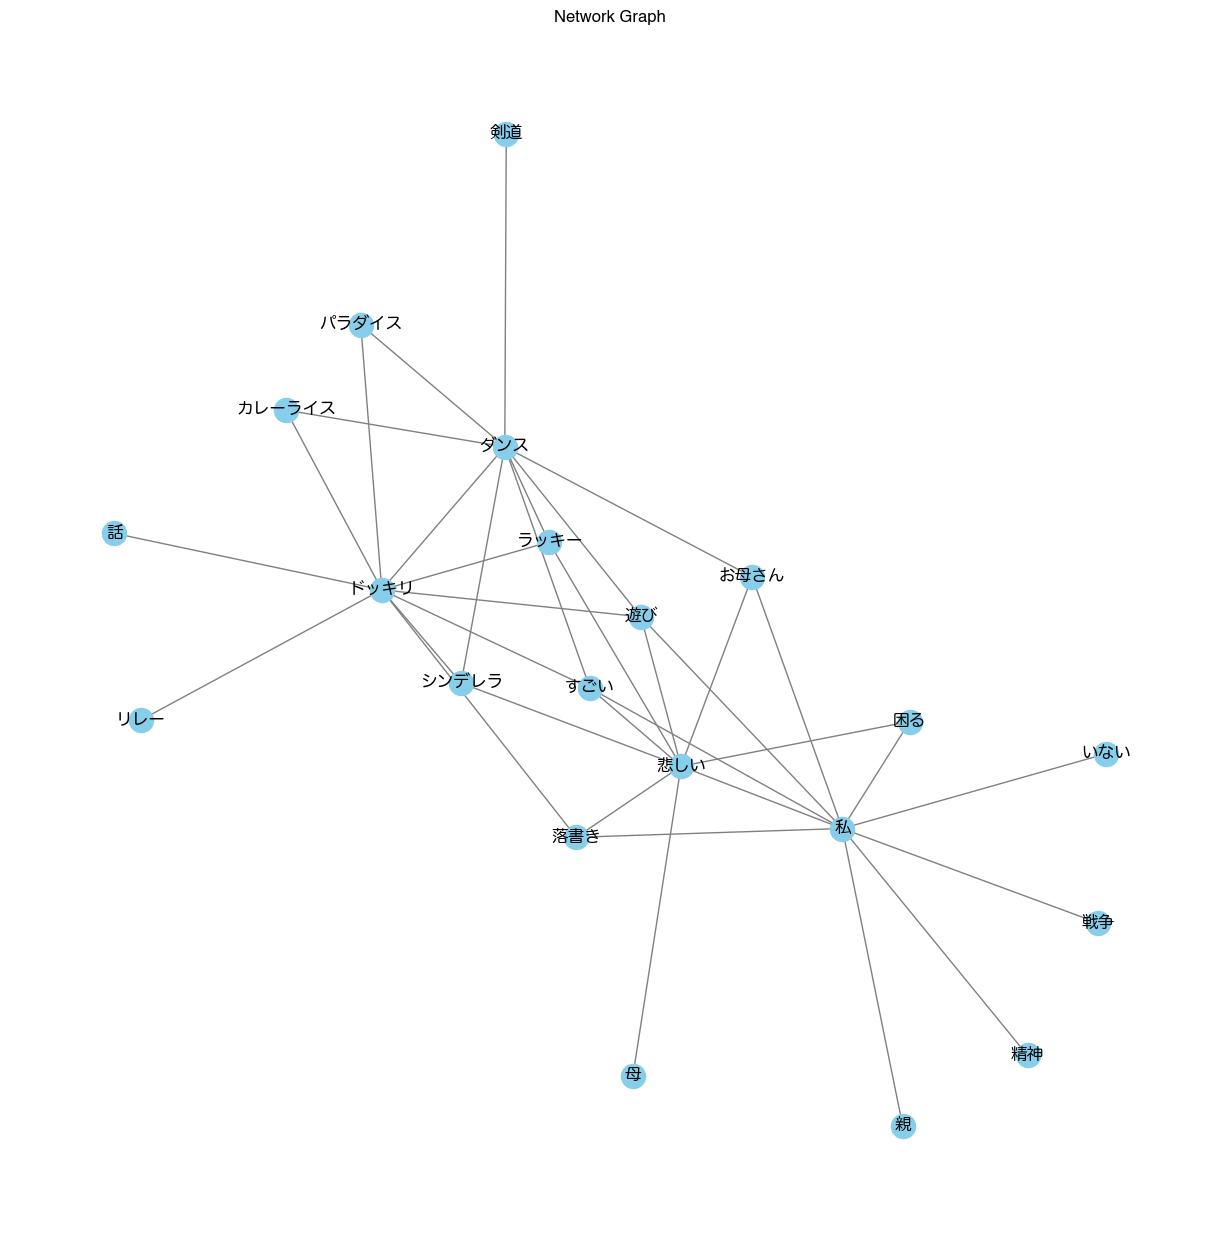

In [10]:
# 日本語フォントの設定
#fm.get_font_config()
import matplotlib
import japanize_matplotlib
#plt.rcParams['font.family'] = 'Hiragino Maru Gothic Pro'
matplotlib.rc('font', family='Helvetica')

# グラフの可視化
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', font_family='Hiragino Maru Gothic Pro')
plt.title("Network Graph")
plt.show()

In [11]:
import matplotlib
print(matplotlib.get_cachedir())

/Users/hironobu/.matplotlib
